In [4]:
!pip install python-louvain

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import ipywidgets as widgets
from IPython.display import display

# Make sure to upload all csv files to session storage before running the notebook

In [6]:
artists = pd.read_csv('artists.csv')
artists.columns = ['url', 'id', 'image', 'nation', 'title', 'totalWorksTitle', 'year']
artists.head()

url                        id  \
0  /en/ancient-egyptian-painting  5d230b31edc2c9fb74ae130a   
1      /en/ancient-greek-pottery  5ced09b1edc2c993247c1ea0   
2     /en/ancient-greek-painting  5ce3c54dedc2c921c4035b7d   
3                    /en/apelles  5ba232ccedc2c918cc654ea8   
4             /en/fayum-portrait  5beea1ededc2c915a01acdda   

                                               image     nation  \
0  https://uploads2.wikiart.org/00244/images/anci...  Egyptians   
1  https://uploads7.wikiart.org/00238/images/anci...     Greeks   
2  https://uploads8.wikiart.org/00237/images/anci...     Greeks   
3  https://uploads2.wikiart.org/00202/images/apel...      Greek   
4  https://uploads7.wikiart.org/00210/images//01....  Egyptians   

                                  title totalWorksTitle                  year  
0                         Ancient Egypt    169 artworks  c.3150 BC - c.640 AD  
1                 Ancient Greek Pottery     87 artworks         c.900 - 31 BC  
2  Ancient Greek Painting and Sculpture     76 artworks       c.700 - c.31 BC  
3                               Apelles      8 artworks         born c.370 BC  
4                        Fayum portrait     76 artworks          c.50 - c.250

In [7]:
institutions = pd.read_csv('institutions.csv')
institutions.head()

city  country                                              title  \
0      NaN      NaN                                Guild of Saint Luke   
1  Antwerp  Belgium                         Royal Academy of Fine Arts   
2   Munich  Germany  Akademie der Bildenden Künste München (Munich ...   
3    Milan    Italy   Accademia di Belle Arti di Brera (Brera Academy)   
4    Paris   France                            Académie des Beaux-Arts   

                                                 url  
0  /en/artists-by-art-institution/guild-of-saint-...  
1  /en/artists-by-art-institution/royal-academy-o...  
2        /en/artists-by-art-institution/akademie-der  
3  /en/artists-by-art-institution/accademia-di-be...  
4  /en/artists-by-art-institution/acad-mie-des-beaux

In [8]:
schools = pd.read_csv('schools.csv')
schools.head()

title                                               url
0     Flemish School     /en/artists-by-painting-school/flemish-school
1     Sienese School     /en/artists-by-painting-school/sienese-school
2     Umbrian school     /en/artists-by-painting-school/umbrian-school
3  Florentine School  /en/artists-by-painting-school/florentine-school
4       Parma school       /en/artists-by-painting-school/parma-school

In [9]:
relationships = pd.read_csv('relationships.csv')
relationships.columns = ['artistUrl', 'friends', 'influenced_by', 'influenced_on', 'institutions', 'movements', 'schools', 'type']
relationships.head()

artistUrl friends               influenced_by  \
0                    /en/apelles     NaN  /en/ancient-greek-painting   
1                   /en/wang-wei     NaN                         NaN   
2  /en/ancient-egyptian-painting     NaN                         NaN   
3                    /en/guanxiu     NaN                         NaN   
4                    /en/han-gan     NaN                         NaN   

                                       influenced_on institutions  \
0                         /en/ancient-greek-painting          NaN   
1                                                NaN          NaN   
2  /en/fayum-portrait,/en/ancient-greek-painting,...          NaN   
3                                                NaN          NaN   
4                                                NaN          NaN   

                                           movements  \
0  Classical Period (480 - 323 BC),Hellenistic Pe...   
1                             Tang Dynasty (618–907)   
2  Early Dynastic Period (3150 – 2686 BC),Old Kin...   
3  Tang Dynasty (618–907),Five Dynasties and Ten ...   
4                             Tang Dynasty (618–907)   

                                             schools         type  
0  /en/artists-by-painting-school/heptanese-ionia...      Artists  
1                                                NaN      Artists  
2                                                NaN  Collections  
3                                                NaN      Artists  
4                                                NaN      Artists

# EDA

In [10]:
# Check for NaN values
print(f"Artists {artists.shape}")
print(artists.isna().sum())
print(f"\nInstitutions {institutions.shape}")
print(institutions.isna().sum())
print(f"\nSchools {schools.shape}")
print(schools.isna().sum())
print(f"\nRelationships {relationships.shape}")
print(relationships.isna().sum())

Artists (2996, 7)
url                 0
id                  0
image               0
nation             32
title               0
totalWorksTitle     0
year                1
dtype: int64

Institutions (73, 4)
city       2
country    2
title      0
url        0
dtype: int64

Schools (220, 2)
title    0
url      0
dtype: int64

Relationships (2996, 8)
artistUrl           0
friends          2580
influenced_by    2512
influenced_on    2637
institutions     2362
movements          40
schools          1966
type                1
dtype: int64


## Artists

In [11]:
artists_clean = artists.copy()

# Change the totalWorksTitle to a number column and removing the text artworks
artists_clean['totalWorksTitle'] = artists_clean['totalWorksTitle'].str.replace(' artworks', '')
artists_clean['totalWorksTitle'] = artists_clean['totalWorksTitle'].str.replace(' artwork', '')
artists_clean['totalWorksTitle'] = artists_clean['totalWorksTitle'].astype(int)

# Merge nationalities which present singular and plural form of the same nationality
artists_clean['nation'] = artists_clean['nation'].str.replace('Americans', 'American')
artists_clean['nation'] = artists_clean['nation'].str.replace('Indigenous North American', 'American')
artists_clean['nation'] = artists_clean['nation'].str.replace('Egyptians', 'Egyptian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Russians', 'Russian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Bulgarians', 'Bulgarian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Germans', 'German')
artists_clean['nation'] = artists_clean['nation'].str.replace('Tunisians', 'Tunisian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Luxembourgers', 'Luxembourger')
artists_clean['nation'] = artists_clean['nation'].str.replace('Croatians', 'Croatian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Ethiopians', 'Ethiopian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Norwegians', 'Norwegian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Austrians', 'Austrian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Ukrainians', 'Ukrainian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Italians', 'Italian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Romanians', 'Romanian')
artists_clean['nation'] = artists_clean['nation'].str.replace('Bangladeshis', 'Bangladeshi')
artists_clean['nation'] = artists_clean['nation'].str.replace('Greeks', 'Greek')
artists_clean['nation'] = artists_clean['nation'].str.replace('Moldovans', 'Moldovan')
artists_clean['nation'] = artists_clean['nation'].str.replace('Palestinians', 'Palestinian')

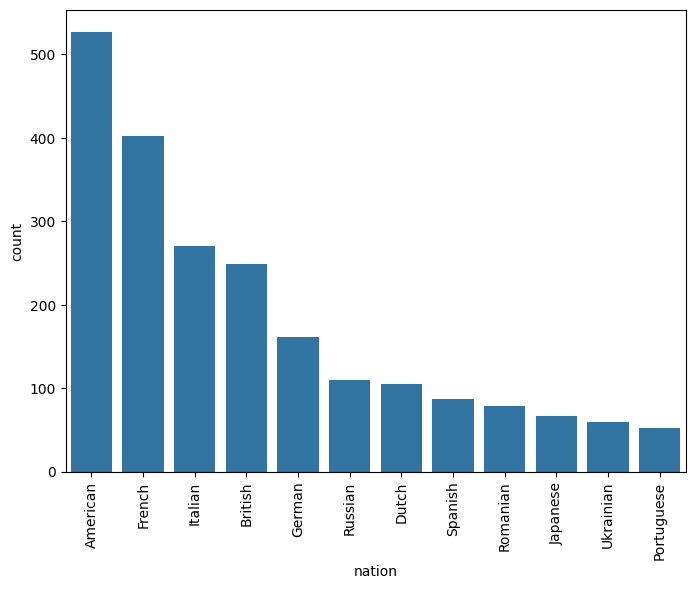

nation
American    527
French      402
Italian     270
British     249
German      161
Russian     110
Dutch       105
Spanish      87
Romanian     79
Japanese     67
Name: count, dtype: int64

In [12]:
# Nationalities distribution
vc = artists_clean['nation'].value_counts()
vc = vc[vc > 50]

plt.figure(figsize=(8, 6))
sns.barplot(x=vc.index, y=vc)
plt.xticks(rotation=90)
plt.show()

vc[:10]

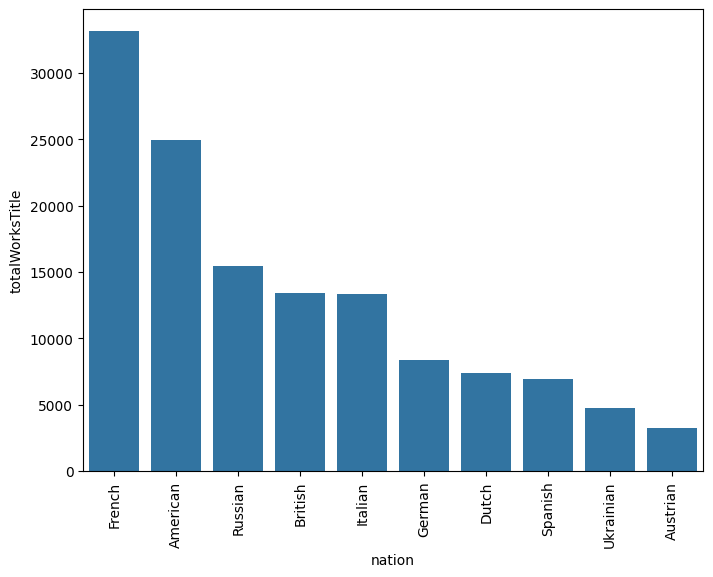

nation  totalWorksTitle
37     French            33142
1    American            24975
73    Russian            15483
16    British            13414
50    Italian            13315
39     German             8357
28      Dutch             7377
80    Spanish             6937
88  Ukrainian             4776
6    Austrian             3238

In [13]:
# Nations vs TotalWorksTitle bar plot
nation_totalwork = artists_clean.groupby('nation')['totalWorksTitle'].sum().reset_index()
nation_totalwork = nation_totalwork.sort_values(by='totalWorksTitle', ascending=False)
nation_totalwork = nation_totalwork.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=nation_totalwork['nation'], y=nation_totalwork['totalWorksTitle'])
plt.xticks(rotation=90)
plt.show()

nation_totalwork.head(10)

## Institutions

In [14]:
institutions_clean = institutions.copy()

# Standardize coutry names
institutions_clean['country'] = institutions_clean['country'].str.replace('NY', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('CA', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('PA', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('OH', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('NC', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('CT', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('MA', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('MD', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('IL', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('New York City', 'USA')
institutions_clean['country'] = institutions_clean['country'].str.replace('UK', 'United Kingdom')

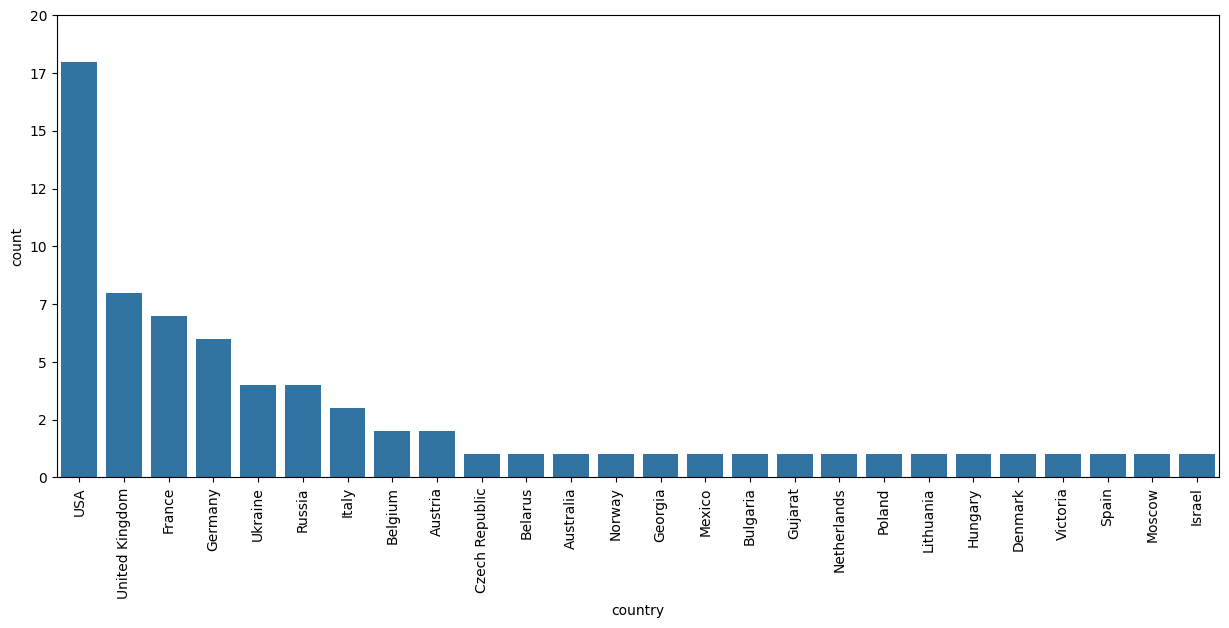

country
USA               18
United Kingdom     8
France             7
Germany            6
Ukraine            4
Name: count, dtype: int64

In [15]:
# Instituition by contry plot
plt.figure(figsize=(15, 6))
sns.barplot(x=institutions_clean['country'].value_counts().index, y=institutions_clean['country'].value_counts())
plt.xticks(rotation=90)
plt.yticks(ticks=plt.yticks()[0], labels=[int(tick) for tick in plt.yticks()[0]]) # Format y ticks as integers
plt.show()

institutions_clean['country'].value_counts()[:5]

## Relationships

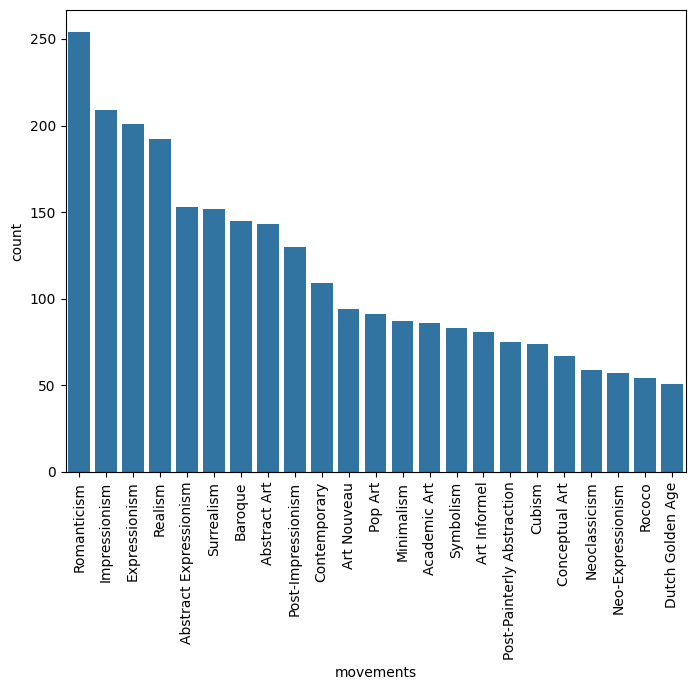

movements
Romanticism               254
Impressionism             209
Expressionism             201
Realism                   192
Abstract Expressionism    153
Surrealism                152
Baroque                   145
Abstract Art              143
Post-Impressionism        130
Contemporary              109
Name: count, dtype: int64

In [16]:
# Movements distribution plot
# Separate movements and insert them into new rows
rel_movements = relationships.copy()
rel_movements['movements'] = rel_movements['movements'].str.split(',')
rel_movements = rel_movements.explode('movements')

vc = rel_movements['movements'].value_counts()
vc = vc[vc > 50]

plt.figure(figsize=(8, 6))
sns.barplot(x=vc.index, y=vc)
plt.xticks(rotation=90)
plt.show()

vc[:10]

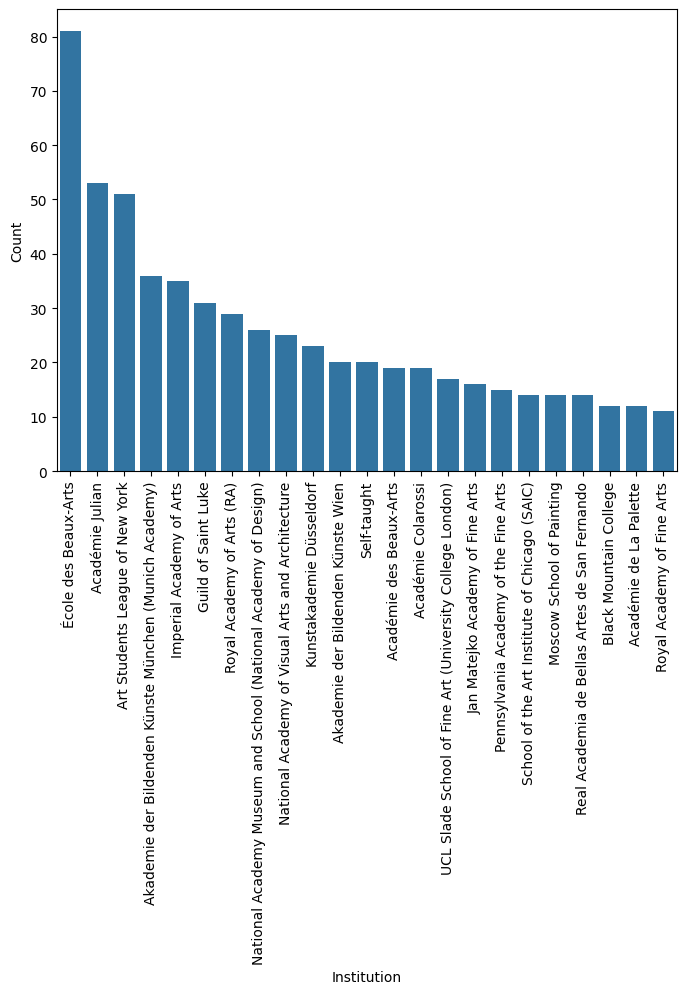

École des Beaux-Arts                                               81
Académie Julian                                                    53
Art Students League of New York                                    51
Akademie der Bildenden Künste München (Munich Academy)             36
Imperial Academy of Arts                                           35
Guild of Saint Luke                                                31
Royal Academy of Arts (RA)                                         29
National Academy Museum and School (National Academy of Design)    26
National Academy of Visual Arts and Architecture                   25
Kunstakademie Düsseldorf                                           23
dtype: int64

In [17]:
# Institution distribution plot
# Separate institutions and insert them into new rows
rel_inst = relationships.copy()
rel_inst['institutions'] = rel_inst['institutions'].str.split(',')
rel_inst = rel_inst.explode('institutions')

vc = rel_inst['institutions'].value_counts()
vc = vc[vc > 10]
mapped_vc = {}

for institution, count in vc.items():
    if institution in institutions_clean['url'].values:
        mapped_vc[institutions_clean[institutions_clean['url'] == institution]['title'].values[0]] = count

vc = pd.Series(mapped_vc)

plt.figure(figsize=(8, 6))
sns.barplot(x=vc.index, y=vc)
plt.xlabel('Institution')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

vc[:10]

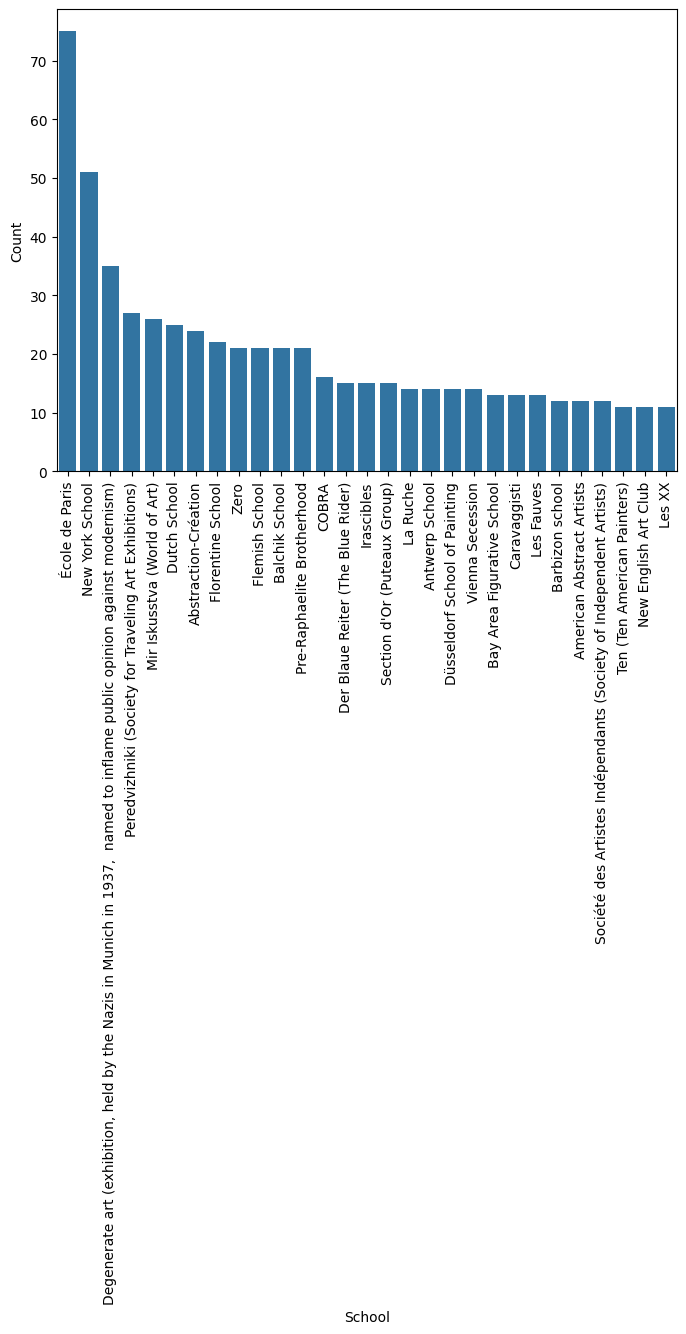

École de Paris                                                                                                          75
New York School                                                                                                         51
Degenerate art (exhibition, held by the Nazis in Munich in 1937,  named to inflame public opinion against modernism)    35
Peredvizhniki (Society for Traveling Art Exhibitions)                                                                   27
Mir Iskusstva (World of Art)                                                                                            26
Dutch School                                                                                                            25
Abstraction-Création                                                                                                    24
Florentine School                                                                                                       22
Zero                                                                                                                    21
Flemish School                                                                                                          21
dtype: int64

In [18]:
# Schools distribution plot
# Separate schools and insert them into new rows
rel_school = relationships.copy()
rel_school['schools'] = rel_school['schools'].str.split(',')
rel_school = rel_school.explode('schools')

vc = rel_school['schools'].value_counts()
vc = vc[vc > 10]
mapped_vc = {}

for school, count in vc.items():
    if school in schools['url'].values:
        mapped_vc[schools[schools['url'] == school]['title'].values[0]] = count

vc = pd.Series(mapped_vc)

plt.figure(figsize=(8, 6))
sns.barplot(x=vc.index, y=vc)
plt.xlabel('School')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

vc[:10]

# Networkx

In [19]:
G = nx.DiGraph()

In [20]:
artist_nodes = artists_clean['url'].tolist()

artists_nations = {}
artists_total_art_works = {}
artists_titles = {}
node_types = {}

for index, row in artists_clean.iterrows():
    artists_titles[row['url']] = row['title']
    artists_nations[row['url']] = row['nation']
    artists_total_art_works[row['url']] = row['totalWorksTitle']
    node_types[row['url']] = 'artist'

G.add_nodes_from(artist_nodes)
nx.set_node_attributes(G, artists_nations, 'nation')
nx.set_node_attributes(G, artists_total_art_works, 'totalWorksTitle')
nx.set_node_attributes(G, artists_titles, 'title')
nx.set_node_attributes(G, node_types, 'type')

In [21]:
institution_nodes = institutions_clean['url'].tolist()

institutions_countries = {}
institutions_cities = {}
institutions_titles = {}
node_types = {}

for index, row in institutions_clean.iterrows():
    institutions_titles[row['url']] = row['title']
    institutions_countries[row['url']] = row['country']
    institutions_cities[row['url']] = row['city']
    node_types[row['url']] = 'institution'

G.add_nodes_from(institution_nodes)
nx.set_node_attributes(G, institutions_countries, 'country')
nx.set_node_attributes(G, institutions_cities, 'city')
nx.set_node_attributes(G, institutions_titles, 'title')
nx.set_node_attributes(G, node_types, 'type')

In [22]:
school_nodes = schools['url'].tolist()

schools_titles = {}
node_types = {}

for index, row in schools.iterrows():
    schools_titles[row['url']] = row['title']
    node_types[row['url']] = 'school'

G.add_nodes_from(school_nodes)
nx.set_node_attributes(G, schools_titles, 'title')
nx.set_node_attributes(G, node_types, 'type')

In [23]:
movement_nodes = rel_movements['movements'].unique().tolist()

node_types = {}

for movement in movement_nodes:
    node_types[movement] = 'movement'

G.add_nodes_from(movement_nodes)
nx.set_node_attributes(G, node_types, 'type')

In [24]:
# Add edges based on artist relationships
for index, row in relationships.iterrows():
  artist = row['artistUrl']

  # Add undirected edges for friends
  if pd.notna(row['friends']) and artist in G.nodes():
    friends = row['friends'].split(',')
    for friend in friends:
      if friend not in G.nodes() or friend == artist or G.has_edge(friend, artist):
        continue
      G.add_edge(artist, friend, rel='friend')
      G.add_edge(friend, artist, rel='friend')

  # Add directed edges for influences
  if pd.notna(row['influenced_by']):
      influenced_by = row['influenced_by'].split(',')
      for influencer in influenced_by:
          if influencer not in G.nodes() or G.has_edge(artist, influencer):
              continue
          G.add_edge(influencer, artist, rel='influenced_on')

  if pd.notna(row['influenced_on']):
      influenced = row['influenced_on'].split(',')
      for influenced_artist in influenced:
          if influenced_artist not in G.nodes() or G.has_edge(artist, influenced_artist):
              continue
          G.add_edge(artist, influenced_artist, rel='influenced_on')

  # Add undirected edges for institutions
  if pd.notna(row['institutions']):
      institutions = row['institutions'].split(',')
      for institution in institutions:
          if institution not in G.nodes() or G.has_edge(artist, institution):
              continue
          G.add_edge(artist, institution, rel='studied_at')

  # Add undirected edges for schools
  if pd.notna(row['schools']):
      schools_list = row['schools'].split(',')
      for school in schools_list:
          if school not in G.nodes() or G.has_edge(artist, school):
              continue
          G.add_edge(artist, school, rel='is_part_of')

  # Addn undirected edges for movements
  if pd.notna(row['movements']):
      movements = row['movements'].split(',')
      for movement in movements:
          if movement not in G.nodes() or G.has_edge(artist, movement):
              continue
          G.add_edge(artist, movement, rel='movement')

In [25]:
print(G)

DiGraph with 3467 nodes and 8154 edges


In [26]:
def create_interactive_graph(G, node_type_filter=None, min_degree=0):
  G_filtered = G.copy()

  # Filter nodes by type if specified
  # By default all subgraphs include artists because they are the ones who have conenctions
  if node_type_filter != 'all':
    G_filtered = G.subgraph([node for node, data in G.nodes(data=True) if data.get('type') == 'artist' or data.get('type') == node_type_filter])

    # If node type is school, only school edges should be included
    if node_type_filter == 'school':
      G_filtered = G_filtered.edge_subgraph([(u, v) for u, v, data in G_filtered.edges(data=True) if data.get('rel') == 'is_part_of']).copy()

    # If node type is movement, only movement edges should be included
    elif node_type_filter == 'movement':
      G_filtered = G_filtered.edge_subgraph([(u, v) for u, v, data in G_filtered.edges(data=True) if data.get('rel') == 'movement']).copy()

    # If node type is institution, only institution edges should be included
    elif node_type_filter == 'institution':
      G_filtered = G_filtered.edge_subgraph([(u, v) for u, v, data in G_filtered.edges(data=True) if data.get('rel') == 'studied_at']).copy()

  filtered_nodes = [node for node, degree in G_filtered.degree() if degree > min_degree]

  if len(filtered_nodes) == 0:
    print("No nodes meet the specified criteria. Lower minimum threshold")
    return

  subgraph = G_filtered.subgraph(filtered_nodes)

  node_degrees = {node: G.degree(node) for node in subgraph.nodes()}

  plt.figure(figsize=(25, 15))
  pos = nx.spring_layout(subgraph, k=0.7)  # k controls the distance between nodes

  # Set node size and color based on degree
  node_sizes = [degree * 100 for degree in node_degrees.values()]

  # Normalize node colors for a colormap
  norm = plt.Normalize(vmin=min(node_degrees.values()), vmax=max(node_degrees.values()))
  node_colors = [plt.cm.Oranges(norm(degree)) for degree in node_degrees.values()]

  # Draw nodes
  nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
  labels = {node: subgraph.nodes[node].get('title', node) for node in subgraph.nodes()}
  nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, font_color='black')

  # Draw edges
  nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True)
  edge_labels = nx.get_edge_attributes(subgraph, 'rel')
  nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=7)

  # Add a color bar to represent the degree
  sm = plt.cm.ScalarMappable(cmap=plt.cm.Oranges, norm=norm)
  sm.set_array([])  # Only needed for color bar
  plt.colorbar(sm, label='Node Degree', ax=plt.gca())

  plt.title(f'Graph Visualization (Type: {node_type_filter}, Min Degree: {min_degree})')
  plt.axis('off')
  plt.show()

node_type_widget = widgets.Select(
    options=['all', 'artist', 'institution', 'school', 'movement'],
    value='artist',
    description='Node Type:',
    disabled=False
)

min_degree_widget = widgets.IntSlider(
    value=20,
    min=0,
    max=100,
    step=1,
    description='Min Degree:',
    continuous_update=False
)

def update_graph(node_type, min_degree):
    create_interactive_graph(G, node_type_filter=node_type, min_degree=min_degree)

# Link the widget changes to the graph update function
interactive_plot = widgets.interactive(create_interactive_graph, G=widgets.fixed(G), node_type_filter=node_type_widget, min_degree=min_degree_widget)

# Display the widgets and the plot
display(interactive_plot)

interactive(children=(Select(description='Node Type:', index=1, options=('all', 'artist', 'institution', 'scho…

# Network Analysis

In [27]:
def visualize_node_with_relationships(G, node):
    if node not in G:
        print(f"Node {node} does not exist in the graph.")
        return

    node_title = G.nodes[node].get('title', node)

    # Get the edges directly connected to the node
    edges = list(G.out_edges(node)) # for artists
    if len(edges) == 0:
        edges = list(G.in_edges(node)) # for every other entity

    # Get all nodes involved in these edges
    related_nodes = {n for edge in edges for n in edge}
    # Include the original node
    related_nodes.add(node)

    subgraph = G.subgraph(related_nodes)

    node_degrees = {node: G.degree(node) for node in subgraph.nodes()}

    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(subgraph, k=0.7)  # k controls the distance between nodes

    # Set node size and color based on degree
    node_sizes = [degree * 100 for degree in node_degrees.values()]

    # Normalize node colors for a colormap
    norm = plt.Normalize(vmin=min(node_degrees.values()), vmax=max(node_degrees.values()))
    node_colors = [plt.cm.Oranges(norm(degree)) for degree in node_degrees.values()]

    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
    labels = {node: subgraph.nodes[node].get('title', node) for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, font_color='black')

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges, edge_color='gray', arrows=True)
    edge_labels = {edge: subgraph[edge[0]][edge[1]]['rel'] for edge in edges if 'rel' in subgraph[edge[0]][edge[1]]}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=7)

    # Add a color bar to represent the degree
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Oranges, norm=norm)
    sm.set_array([])  # Only needed for color bar
    plt.colorbar(sm, label='Node Degree', ax=plt.gca())

    plt.title(f'Graph Visualization for {node_title}')
    plt.axis('off')
    plt.show()

def visualize_nodes(G, nodes, min_degree, name):
    G_filtered = G.subgraph(nodes)

    filtered_nodes = [node for node, degree in G_filtered.degree() if degree > min_degree]
    subgraph = G_filtered.subgraph(filtered_nodes)

    node_degrees = {node: G.degree(node) for node in subgraph.nodes()}

    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(subgraph, k=0.7)  # k controls the distance between nodes

    # Set node size and color based on degree
    node_sizes = [degree * 100 for degree in node_degrees.values()]

    # Normalize node colors for a colormap
    norm = plt.Normalize(vmin=min(node_degrees.values()), vmax=max(node_degrees.values()))
    node_colors = [plt.cm.Oranges(norm(degree)) for degree in node_degrees.values()]

    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
    labels = {node: subgraph.nodes[node].get('title', node) for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, font_color='black')

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True)
    edge_labels = nx.get_edge_attributes(subgraph, 'rel')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=7)

    # Add a color bar to represent the degree
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Oranges, norm=norm)
    sm.set_array([])  # Only needed for color bar
    plt.colorbar(sm, label='Node Degree', ax=plt.gca())

    plt.title(f'Graph Visualization for node group {name} with min degree {min_degree}')
    plt.axis('off')
    plt.show()


Pablo Picasso: 30
Paul Cezanne: 23
Caravaggio: 21
Rembrandt: 20
Titian: 18


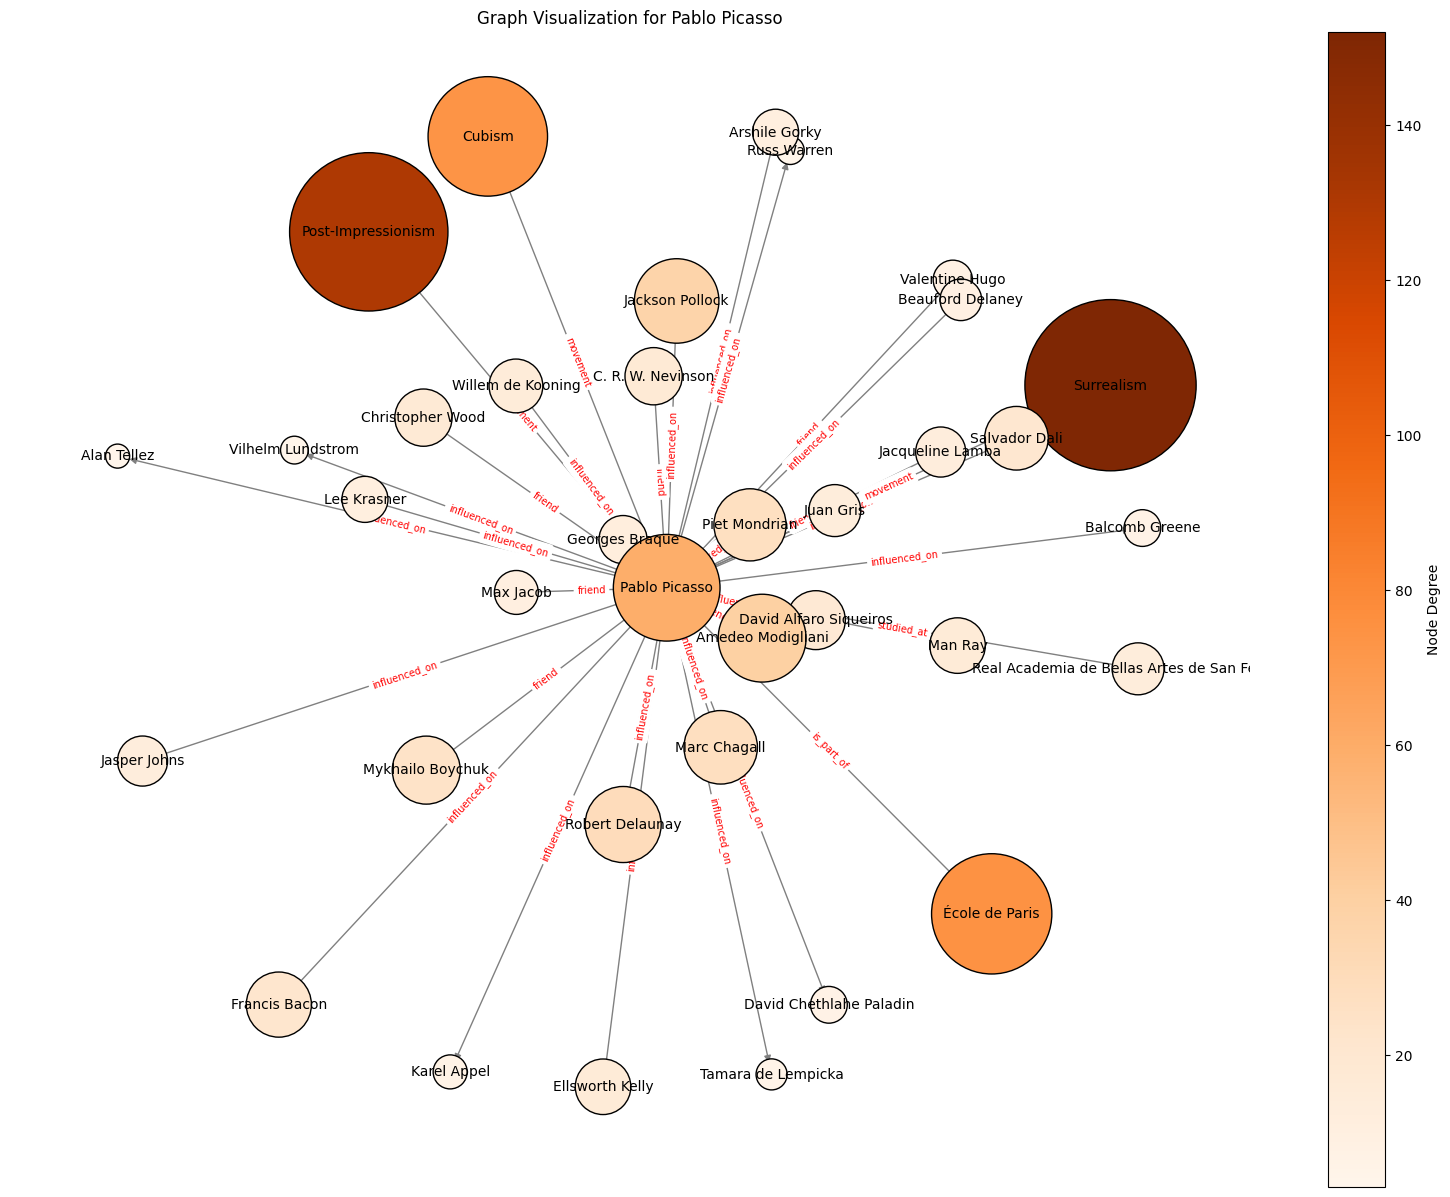

In [28]:
# 1. Which were the most influential artists?
influence_count = {}

# Iterate over the edges to count influences
for u, v, attr in G.edges(data=True):
    if attr['rel'] == 'influenced_on' or attr['rel'] == 'friend':
        influence_count[u] = influence_count.get(u, 0) + 1

# Map urls to titles
new_influence_count = {}
for artistUrl, influence in influence_count.items():
    if artistUrl not in artists_clean['url'].values: # School influences, will not be included
        continue
    else:
        new_influence_count[artists_clean[artists_clean['url'] == artistUrl]['title'].values[0]] = influence
influence_count = new_influence_count

# Find the top 5 artists and their influence count
top_influential_artists = sorted(influence_count, key=influence_count.get, reverse=True)[:5]

for artist in top_influential_artists:
    print(f"{artist}: {influence_count[artist]}")

visualize_node_with_relationships(G, artists_clean[artists_clean['title'] == top_influential_artists[0]]['url'].values[0])

Romanticism: 254
Impressionism: 209
Expressionism: 201
Realism: 192
Abstract Expressionism: 153


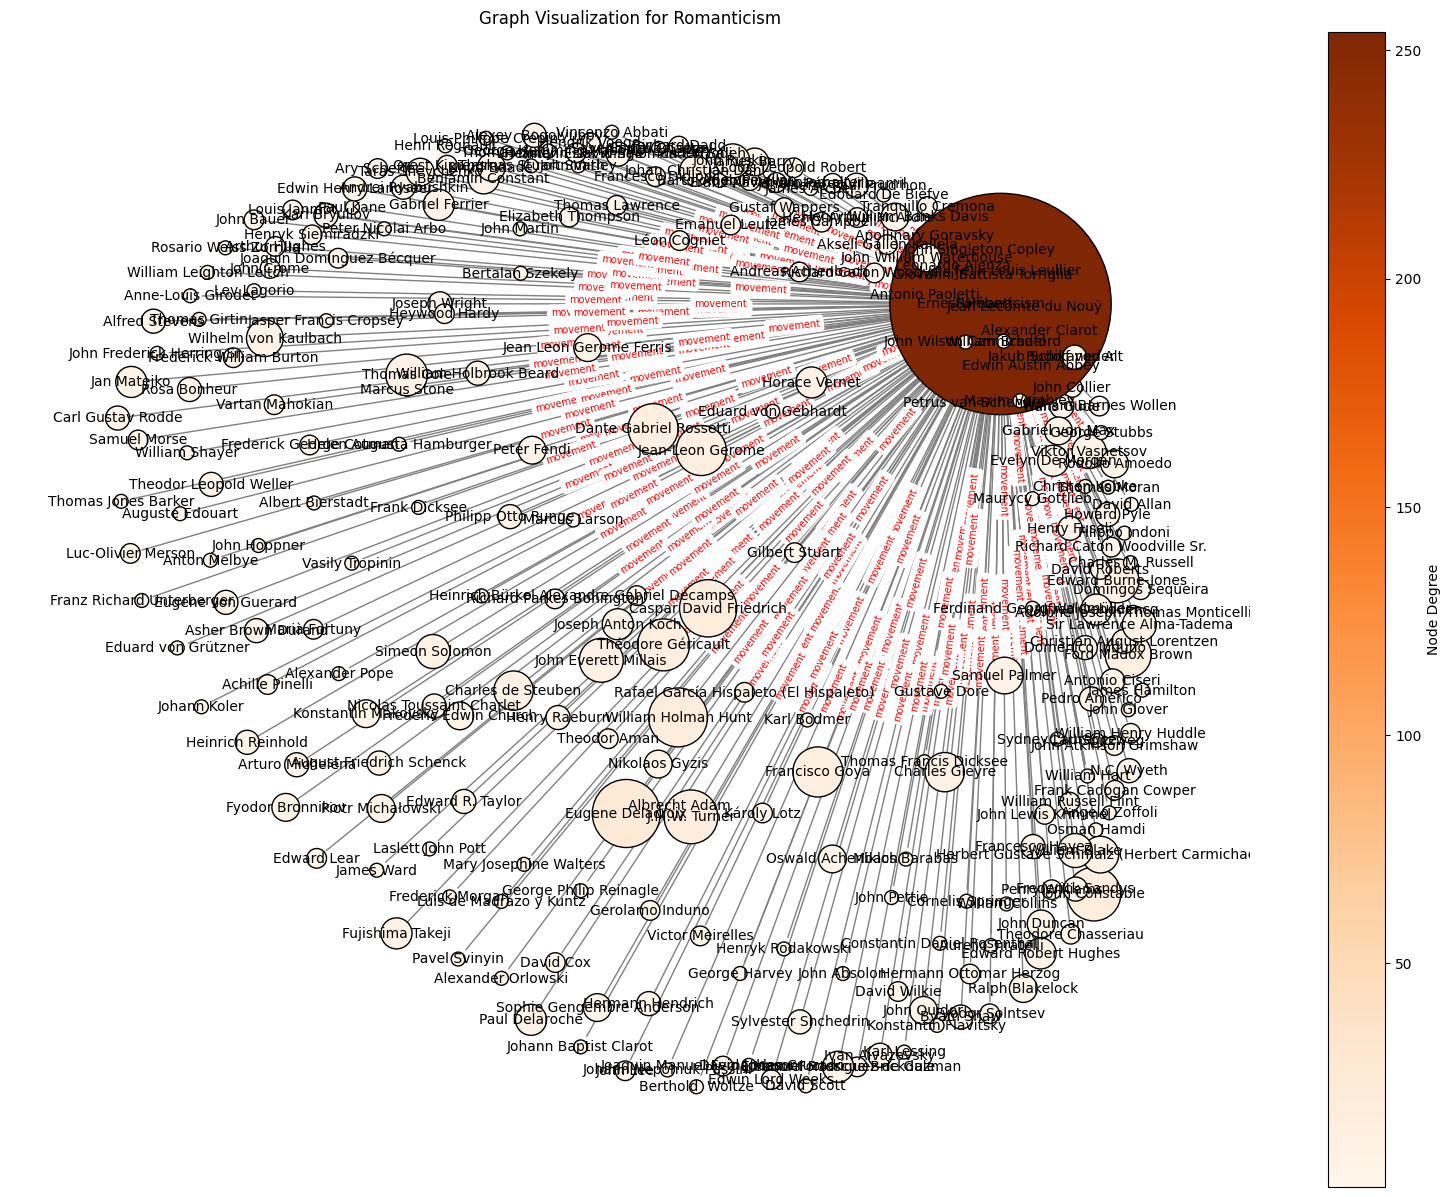

In [29]:
# 2. Which were the most influential movements?
movement_count = {}

# Iterating over the edges to count movements
for u, v, attr in G.edges(data=True):
    if attr['rel'] == 'movement':
        if v not in movement_count:
            movement_count[v] = 0
        movement_count[v] += 1

# Finding the top 5 movements
top_movements = sorted(movement_count, key=movement_count.get, reverse=True)[:5]

for movement in top_movements:
    print(f"{movement}: {movement_count[movement]}")

visualize_node_with_relationships(G, top_movements[0])

École des Beaux-Arts: 81
Académie Julian: 53
Art Students League of New York: 51
Akademie der Bildenden Künste München (Munich Academy): 36
Imperial Academy of Arts: 35


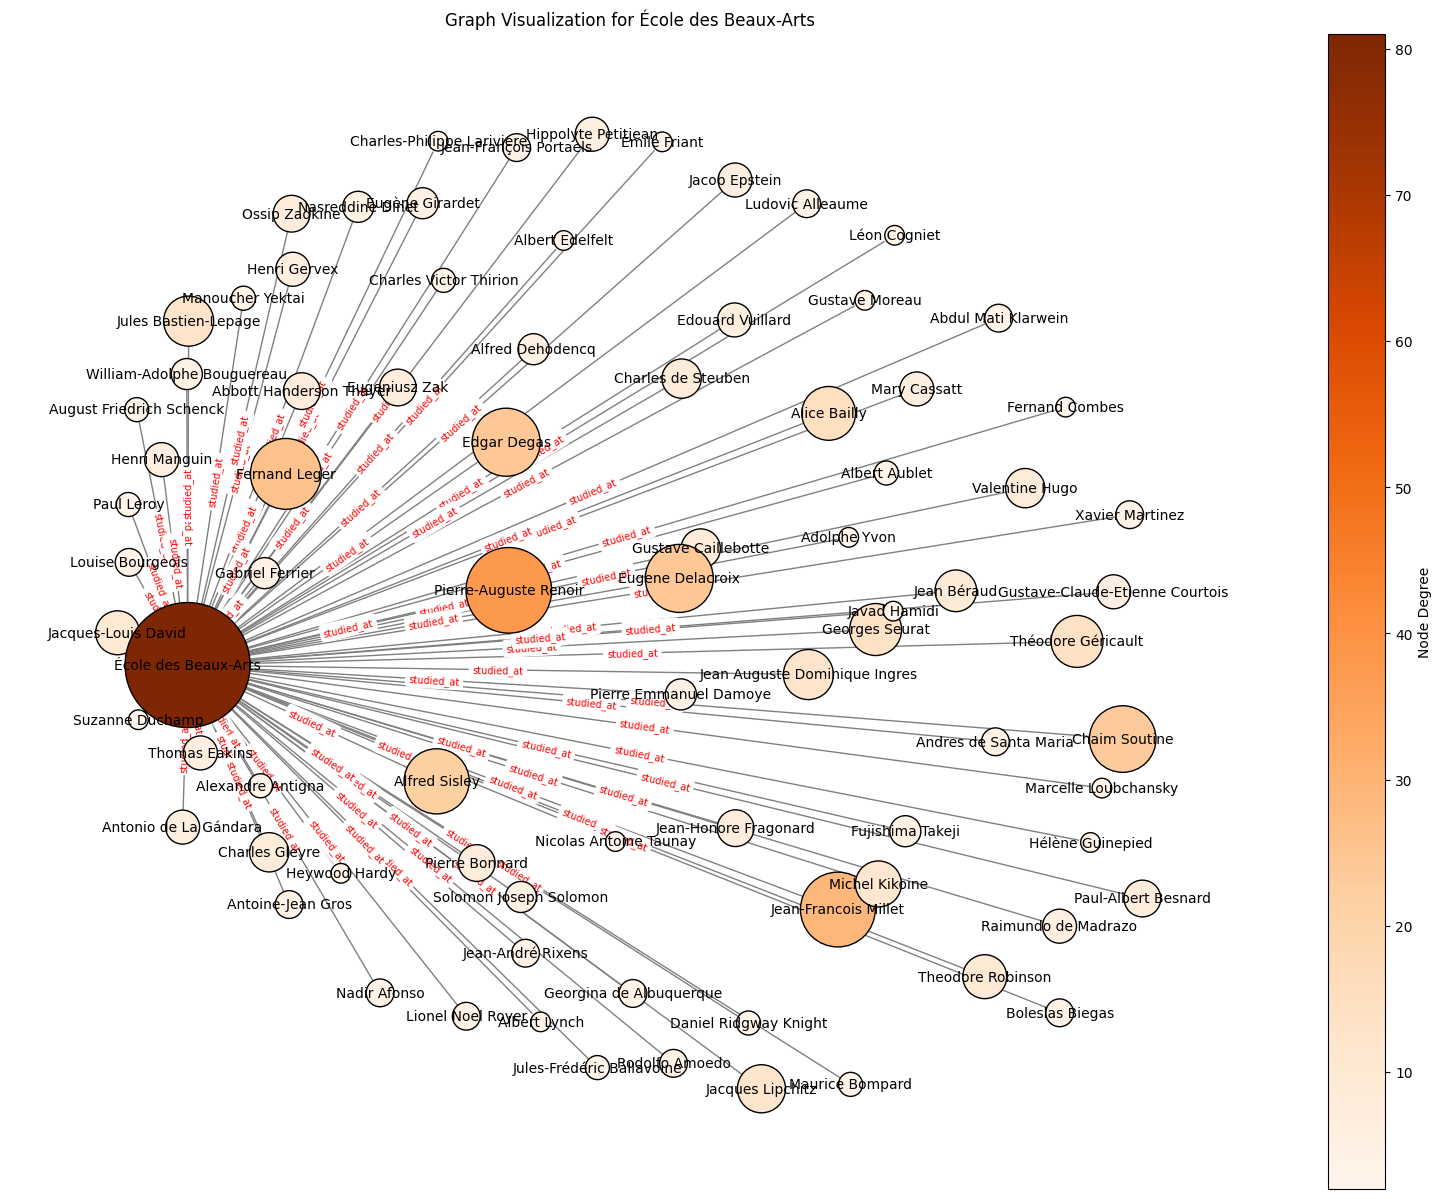

In [30]:
# 3. Which were the most influential institutions?
institution_count = {}

# Iterating over the edges to count institutions
for u, v, attr in G.edges(data=True):
    if attr['rel'] == 'studied_at':
        if v not in institution_count:
            institution_count[v] = 0
        institution_count[v] += 1

# Mapping urls to titles
institution_count = {institutions_clean[institutions_clean['url'] == url]['title'].values[0]: count for url, count in institution_count.items()}

# Finding the top 5 institutions
top_institutions = sorted(institution_count, key=institution_count.get, reverse=True)[:5]

for institution in top_institutions:
    print(f"{institution}: {institution_count[institution]}")

visualize_node_with_relationships(G, institutions_clean[institutions_clean['title'] == top_institutions[0]]['url'].values[0])

American: 527
French: 402
Italian: 270
British: 249
German: 161


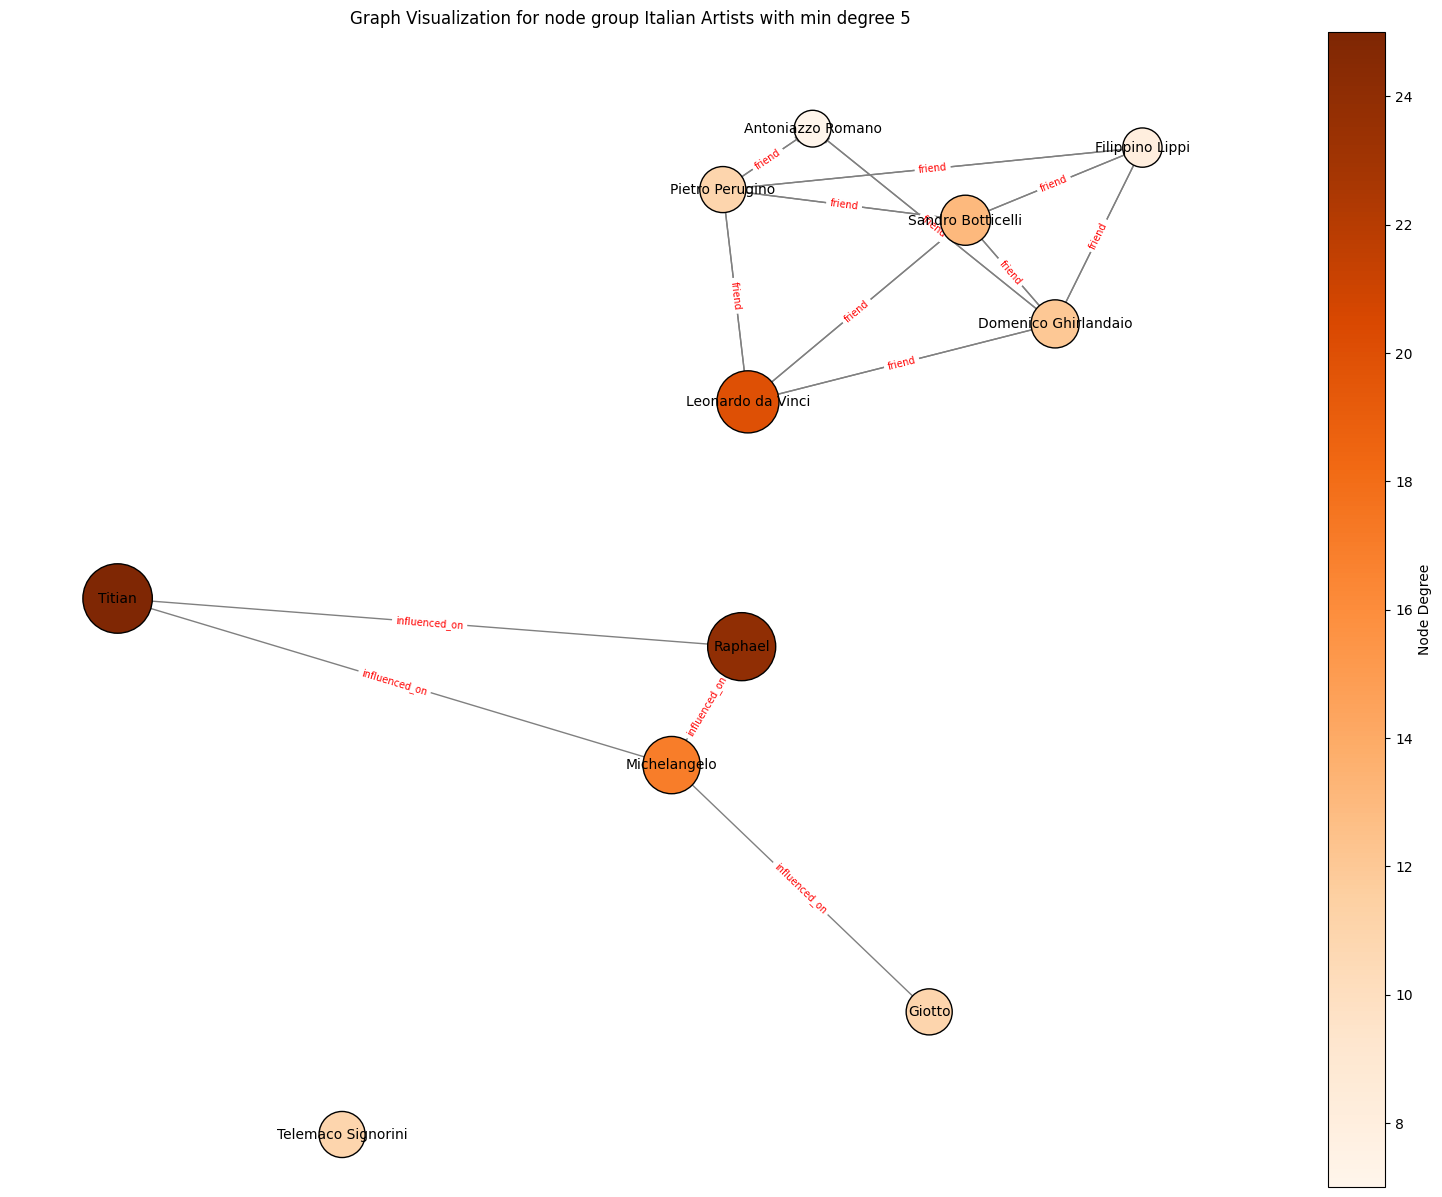

In [31]:
# 4. Which nationalities concentrate the majority of artists?
nation_count = {}

for node in G.nodes():
    nation = G.nodes[node].get('nation')
    if nation is not None:
        if nation not in nation_count:
            nation_count[nation] = 0
        nation_count[nation] += 1

# Finding the top 5 nations
top_nations = sorted(nation_count, key=nation_count.get, reverse=True)[:5]

for nation in top_nations:
    print(f"{nation}: {nation_count[nation]}")

# Visualizing all German artists
italian_artists = [node for node, data in G.nodes(data=True) if data.get('nation') == 'Italian']
visualize_nodes(G, italian_artists, 5, 'Italian Artists')

In [32]:
# 5. Which are the biggest communities in the network?
def analyze_communities(communities):
  print(f'Found {len(communities)} communities')

  community_sizes = []
  for community_id in communities:
    community_sizes.append((community_id, len(community_id)))

  # Find the top 5 largest communities
  largest_communities = sorted(community_sizes, key=lambda x: x[1], reverse=True)[:5]

  # Find the most influential person within each of the top 5 largest communities
  most_influential_artists_in_biggest_communities = []

  for community_id, community_size in largest_communities:
      community_nodes = [undirected_artist_subgraph.nodes()[node]['title'] for node in undirected_artist_subgraph.nodes() if node in community_id]

      artist = community_nodes[0]
      influence = influence_count[artist] if artist in influence_count else 0

      for node in community_nodes:
          if node in influence_count and influence_count[node] > influence:
              artist = node
              influence = influence_count[node]

      most_influential_artists_in_biggest_communities.append([community_id, community_size, artist, influence])

  print("Most Influential Artists in the Top 5 Largest Communities:\n")
  for _, community_size, artist, influence in most_influential_artists_in_biggest_communities:
      print(f"Community Size: {community_size}")
      print(f"Most Influential Artist: {artist}, Influence: {influence}")
  print("\n")

  community_id = largest_communities[0][0]
  community_nodes = [node for node in undirected_artist_subgraph.nodes() if node in community_id]
  return community_nodes

# Subgraph with only artists nodes
artits_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'artist']
artist_subgraph = G.subgraph(artits_nodes)

# Converting the directed graph to an undirected graph for community detection
undirected_artist_subgraph = artist_subgraph.to_undirected()

# Detecting communities using the Louvain method
communities = community.louvain_communities(undirected_artist_subgraph)
nodes1 = analyze_communities(communities)

# Detecting communities using the greedy method
communities = community.greedy_modularity_communities(undirected_artist_subgraph)
nodes2 = analyze_communities(communities)

# Detecting communities using the fast label propagation method
communities = community.fast_label_propagation_communities(undirected_artist_subgraph)
communities = [frozenset(community) for community in communities]
nodes3 = analyze_communities(communities)

Found 2259 communities
Most Influential Artists in the Top 5 Largest Communities:

Community Size: 89
Most Influential Artist: Paul Cezanne, Influence: 23
Community Size: 66
Most Influential Artist: Pablo Picasso, Influence: 30
Community Size: 62
Most Influential Artist: Titian, Influence: 18
Community Size: 59
Most Influential Artist: Wassily Kandinsky, Influence: 15
Community Size: 50
Most Influential Artist: Giorgio de Chirico, Influence: 10


Found 2260 communities
Most Influential Artists in the Top 5 Largest Communities:

Community Size: 153
Most Influential Artist: Pablo Picasso, Influence: 30
Community Size: 116
Most Influential Artist: Caravaggio, Influence: 21
Community Size: 112
Most Influential Artist: Jackson Pollock, Influence: 14
Community Size: 83
Most Influential Artist: Raphael, Influence: 16
Community Size: 57
Most Influential Artist: Edgar Degas, Influence: 12


Found 2324 communities
Most Influential Artists in the Top 5 Largest Communities:

Community Size: 143
Mo

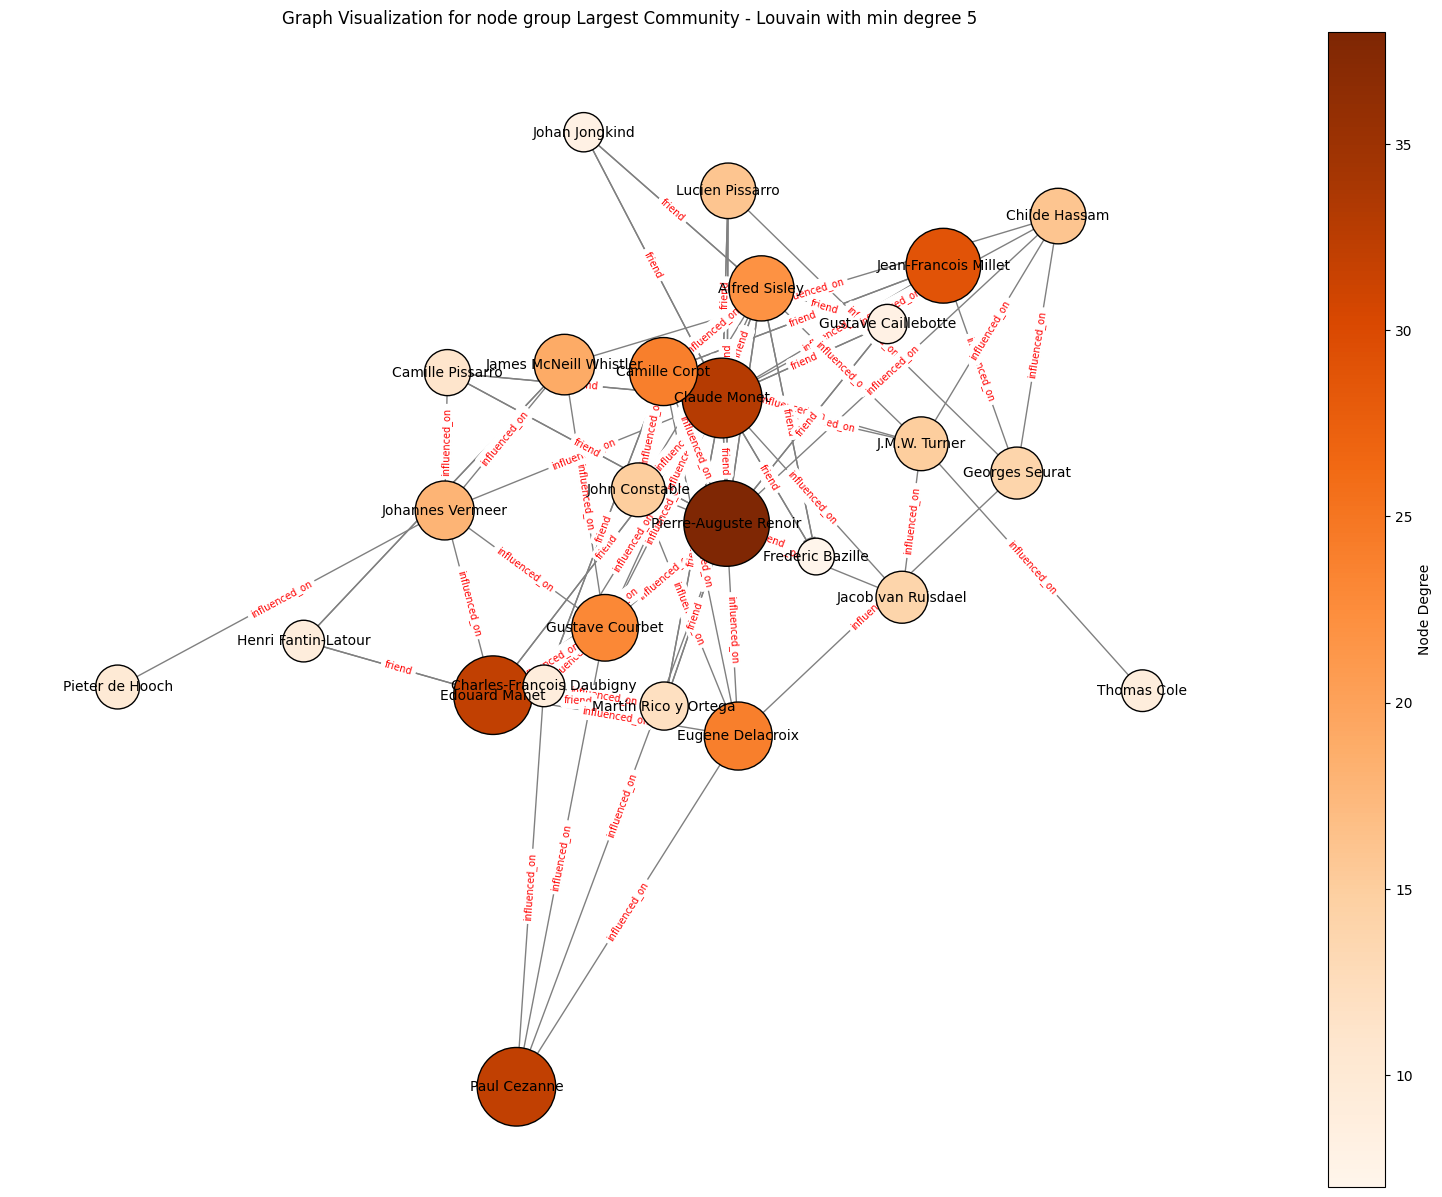

In [33]:
visualize_nodes(G, nodes1, 5, 'Largest Community - Louvain')

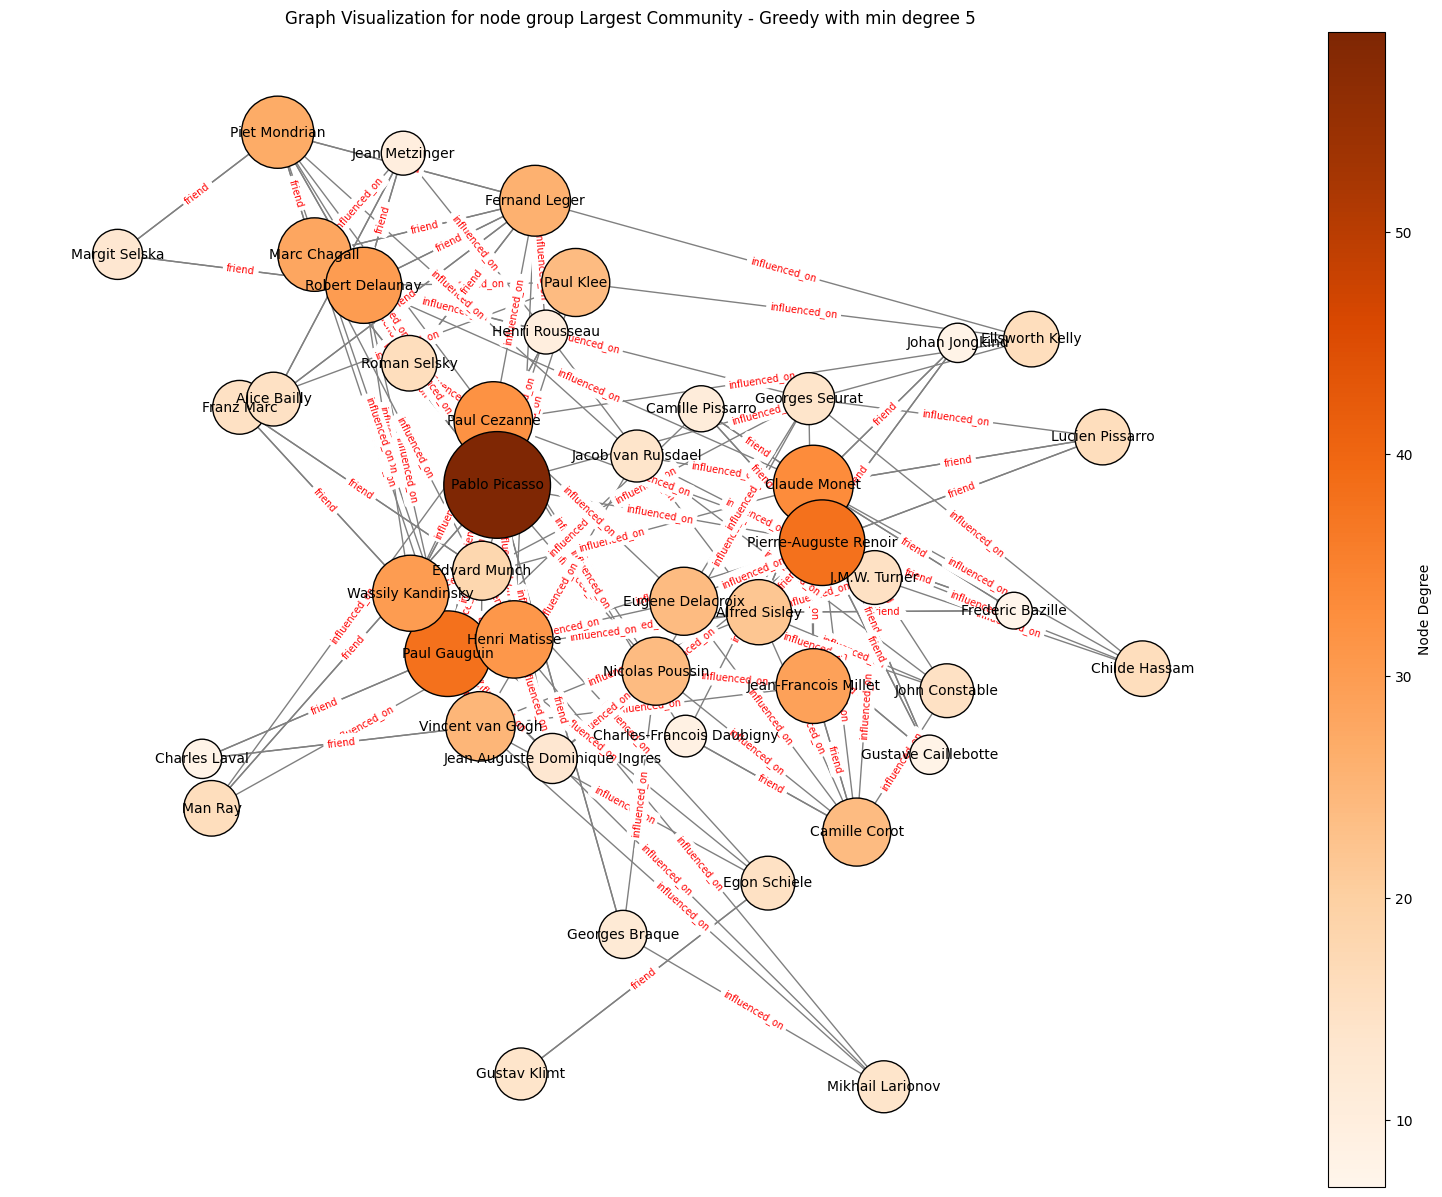

In [34]:
visualize_nodes(G, nodes2, 5, 'Largest Community - Greedy')

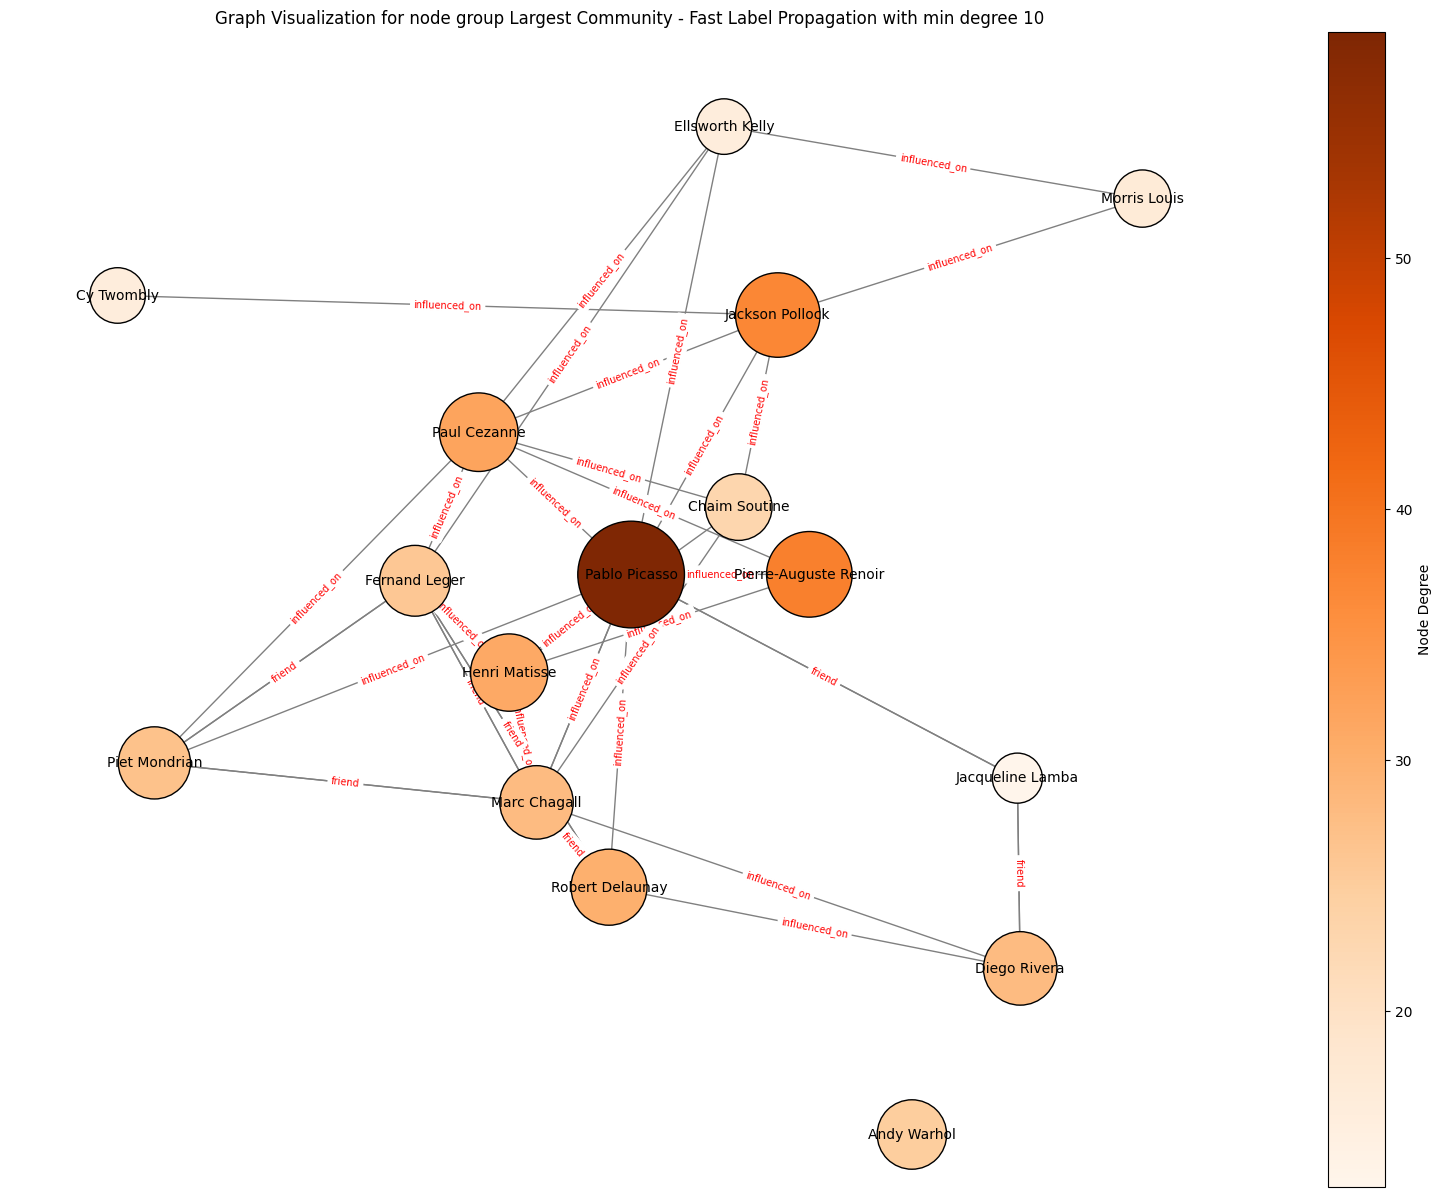

In [35]:
visualize_nodes(G, nodes3, 10, 'Largest Community - Fast Label Propagation')